# <center><font color = "green">PUBG Game Prediction</font><center>

<center><img src = "https://www.icegif.com/wp-content/uploads/2023/02/icegif-237.gif"><center>

### Table Content 

1. [Importing Libraries](#import)
2. [Reading Data](#read)
3. [Data Wrangling](#wrangle)
4. [Feature Engineering](#feature)
5. [ML - CatBoost Model](#cat)

In [1]:
# standard libraries
import numpy as np
import pandas as pd
import seaborn as sns

# visualisation
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (16, 6)    # to set the deafault parameters for the plot

# handling warnings
import warnings
warnings.filterwarnings("ignore")


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import catboost as cb                       # This will be our ML algorithm 

# for evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# <font color = "green">Reading the Data </font><a class = "anchor" id = "read"></a>

In [2]:
# load the data
df = pd.read_csv("PUBG_Game_Prediction_data.csv/PUBG_Game_Prediction_data.csv")

In [3]:
# Data Dimension
df.shape 

(4446966, 29)

In [4]:
# glimpse of the data
df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


### Data Descritption

- <b>DBNOs -</b> Number of enemy players knocked.
- **assists -** Number of enemy players this player damaged that were killed by teammates.
- **boosts -** Number of boost items used.
- **damageDealt -** Total damage dealt. Note: Self inflicted damage is subtracted.
- **headshotKills -** Number of enemy players killed with headshots.
- **heals -** Number of healing items used.
- **Id -** Player’s Id
- **killPlace -** Ranking in match of number of enemy players killed.
- **killPoints -** Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.
- **killStreaks -** Max number of enemy players killed in a short amount of time.
- **kills -** Number of enemy players killed.
- **longestKill -** Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.
- **matchDuration -** Duration of match in seconds.
- **matchId -** ID to identify match. There are no matches that are in both the training and testing set.
- **matchType -** String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.
- **rankPoints -** Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.
- **revives -** Number of times this player revived teammates.
- **rideDistance -** Total distance traveled in vehicles measured in meters.
- **roadKills -** Number of kills while in a vehicle.
- **swimDistance -** Total distance traveled by swimming measured in meters.
- **teamKills -** Number of times this player killed a teammate.
- **vehicleDestroys -** Number of vehicles destroyed.
- **walkDistance -** Total distance traveled on foot measured in meters.- 
- **weaponsAcquired -** Number of weapons picked up.
- **winPoints -** Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.
- **groupId -** ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.
- **numGroups -** Number of groups we have data for in the match.
- **maxPlace -** Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
- **winPlacePerc -** The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

# <font color = "green">Data Wrangling</font><a class = "anchor" id = "wrangle"></a>

#### Check for the rows with missing win prediction value 

In [5]:
# check row with NULL values
df[df['winPlacePerc'].isnull()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,...,0,0.0,0,0.0,0,0,0.0,0,0,NaN


In [6]:
# remove the data row
df.drop(2744604, inplace= True)

#### Understanding Players distribution in a game

In [7]:
# prepare new parameter to know how many players are in a game
df["playersJoined"] = df.groupby('matchId')["matchId"].transform("count")

In [8]:
df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0.0000,0,0.00,0,0,244.80,1,1466,0.4444,96
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0.0045,0,11.04,0,0,1434.00,5,0,0.6400,91
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0.0000,0,0.00,0,0,161.80,2,0,0.7755,98
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0.0000,0,0.00,0,0,202.70,3,0,0.1667,91
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0.0000,0,0.00,0,0,49.75,2,0,0.1875,97


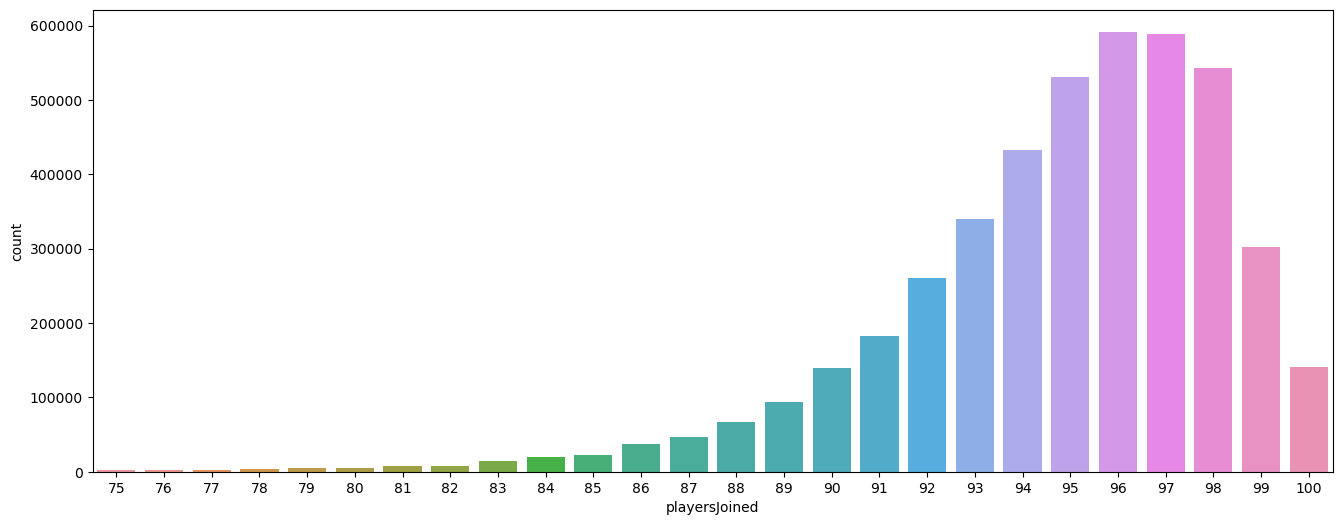

In [9]:
sns.countplot(data=df[df['playersJoined'] >= 75], x='playersJoined')
plt.show()

## Analysing the data

##### Kills Without Moving?

<center><img src = "https://media.giphy.com/media/OPRbXcsGctvZC/giphy.gif"></center>

In [10]:
# prepare a data parameter to gather the information of the total distance travelled
df['TotalDistance'] = df['rideDistance'] + df['walkDistance'] + df['swimDistance']

# prepare a data parameter to check for anamoly detection that
# the person has not moved but still managed to do the kills
df['killswithoutMoving'] = ((df['kills']>0) & (df['TotalDistance'] ==0))

In [11]:
df[df["killswithoutMoving"]==True]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,TotalDistance,killswithoutMoving
1824,b538d514ef2476,0eb2ce2f43f9d6,35e7d750e442e2,0,0,593.000,0,0,3,18,...,0.0,0,0,0.0,8,0,0.8571,58,0.0,True
6673,6d3a61da07b7cb,2d8119b1544f87,904cecf36217df,2,0,346.600,0,0,6,33,...,0.0,0,0,0.0,22,0,0.6000,42,0.0,True
11892,550398a8f33db7,c3fd0e2abab0af,db6f6d1f0d4904,2,0,1750.000,0,4,5,3,...,0.0,0,0,0.0,13,0,0.8947,21,0.0,True
14631,58d690ee461e9d,ea5b6630b33d67,dbf34301df5e53,0,0,157.800,0,0,0,69,...,0.0,0,0,0.0,7,1500,0.0000,73,0.0,True
15591,49b61fc963d632,0f5c5f19d9cc21,904cecf36217df,0,0,100.000,0,1,0,37,...,0.0,0,0,0.0,10,0,0.3000,42,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4440232,1f3a6d69d22c7e,60b2849191c539,ff9cd80c0d8fb7,0,0,4.316,0,0,0,61,...,0.0,0,0,0.0,7,1500,0.8889,75,0.0,True
4440898,a089cb33a75968,eda174acfb503b,4c6b1a0e4cb346,0,0,90.830,0,0,4,42,...,0.0,0,0,0.0,8,0,0.0000,49,0.0,True
4440927,0634c650048997,5ccccee03a7f17,fc0bbecba8db99,2,2,909.100,7,2,16,26,...,0.0,0,0,0.0,7,1500,0.6000,47,0.0,True
4441511,f5d385cadfab7e,a068f79011113c,fc0bbecba8db99,6,2,696.400,9,2,0,18,...,0.0,1,0,0.0,16,1500,0.9000,47,0.0,True


In [12]:
# drop the table
df.drop(df[df["killswithoutMoving"]== True].index, inplace =True)

#### Extra-ordinary Road Kills?????

<center><img src = "https://media.giphy.com/media/3o7aD85usFbbbrCR3i/giphy.gif"></center>

In [13]:
df[df['roadKills'] > 5].shape

(46, 32)

In [14]:
df.drop(df[df['roadKills'] > 5].index, inplace = True)

#### So many KILLS - how ????

<center><img src = "https://media.giphy.com/media/3oxHQfzBhpKtgdDWtW/giphy.gif"></center>

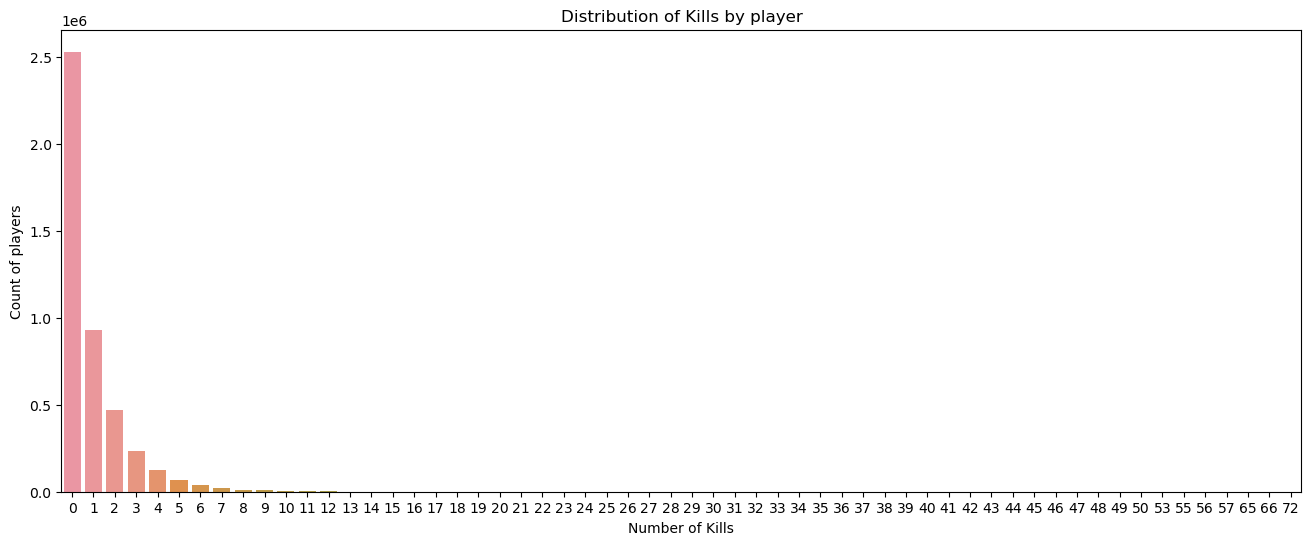

In [16]:
sns.countplot(data = df, x= df['kills']).set_title("Distribution of Kills by player")
plt.ylabel("Count of players")
plt.xlabel("Number of Kills")
plt.show()

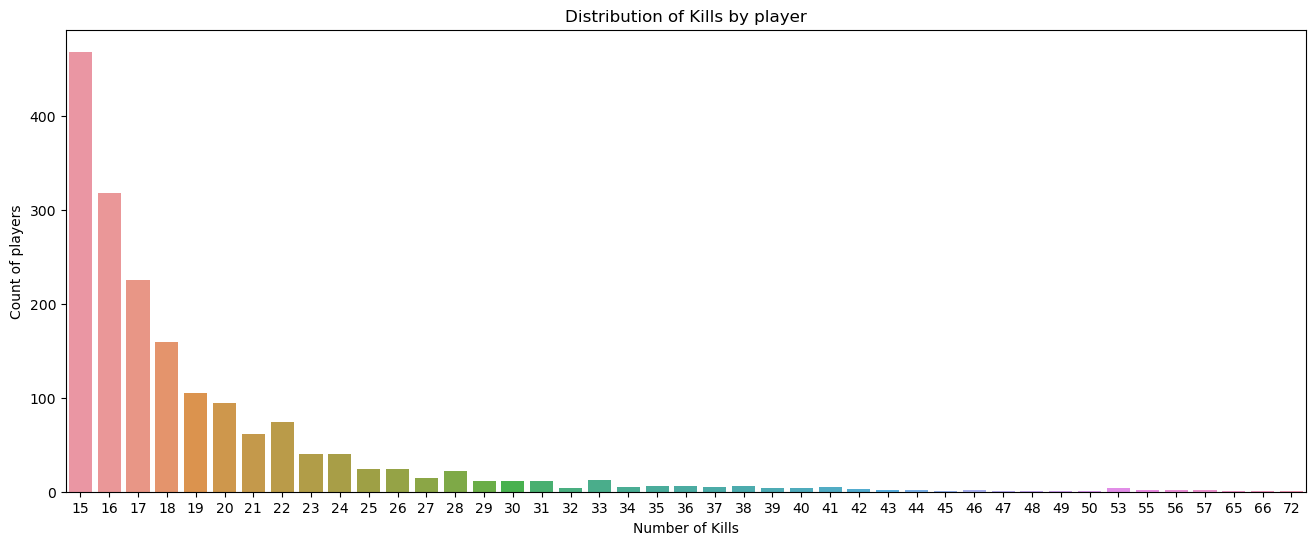

In [23]:
sns.countplot(data = df[df["kills"]>=15], x= "kills").set_title("Distribution of Kills by player")
plt.ylabel("Count of players")
plt.xlabel("Number of Kills")
plt.show()

In [24]:
# data dimension
df[df['kills']> 20].shape

(417, 32)

In [25]:
# data dimension
df.drop(df[df['kills'] > 20].index, inplace = True)

#### Head Shot

<center><img src = "https://media.giphy.com/media/l3mZrOajz5VCZf7Hy/giphy.gif"></center>

In [30]:
df['headshot_rate'] = df['headshotKills']/df['kills']
df['headshot_rate'] = df['headshot_rate'].fillna(0)

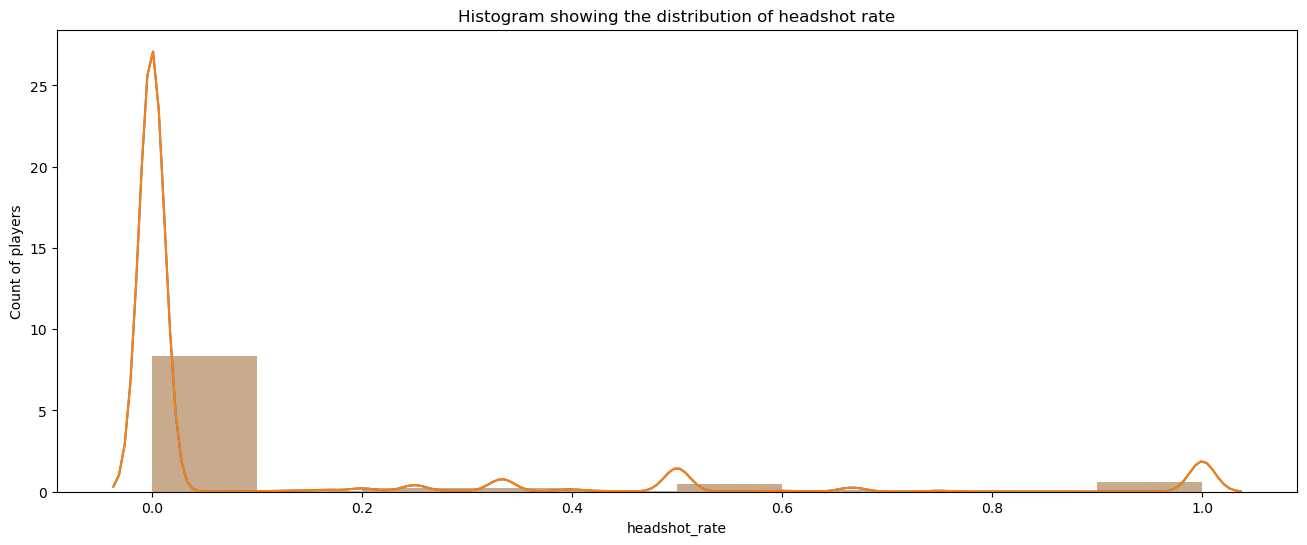

In [32]:
# plot the headshot rate distribution
sns.distplot(df['headshot_rate'], bins =10).set_title("Histogram showing the distribution of headshot rate")
sns.distplot(df['headshot_rate'], bins =10).set_title("Histogram showing the distribution of headshot rate")
plt.ylabel("Count of players")
plt.show()

In [33]:
df[(df['headshot_rate'] ==1) & (df['kills']>5)].shape

(187, 33)

In [34]:
df.drop(df[(df['headshot_rate'] == 1)& (df['kills'] > 6)].index, inplace = True)

#### Longest Shot

<center><img src = "https://media.giphy.com/media/3ohs7YomxqOz4GRHcQ/giphy.gif"></center>

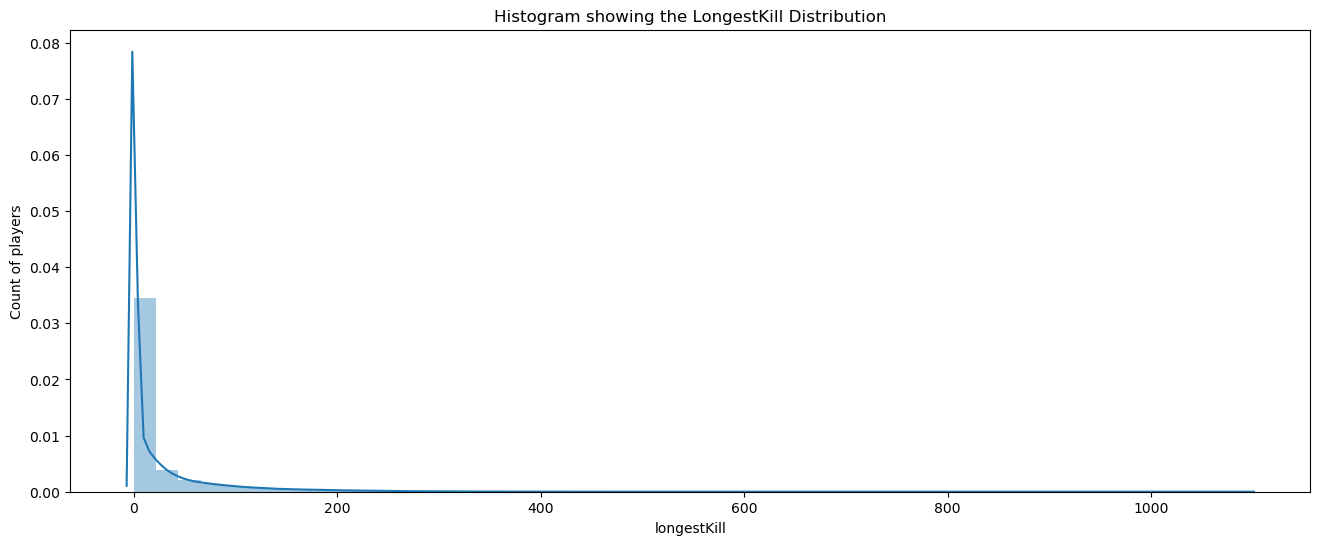

In [35]:
sns.distplot(df['longestKill'], bins = 50).set_title("Histogram showing the LongestKill Distribution")
plt.ylabel("Count of players")
plt.show()

In [36]:
df[df['longestKill']>=500].shape

(1747, 33)

In [37]:
# drop the rows with longest kills (abobe 500 meters)
df.drop(df[df['longestKill']>=500].index, inplace = True) 

#### Weapon Change

<center><img src = "https://j.gifs.com/3loOmn.gif"></center>

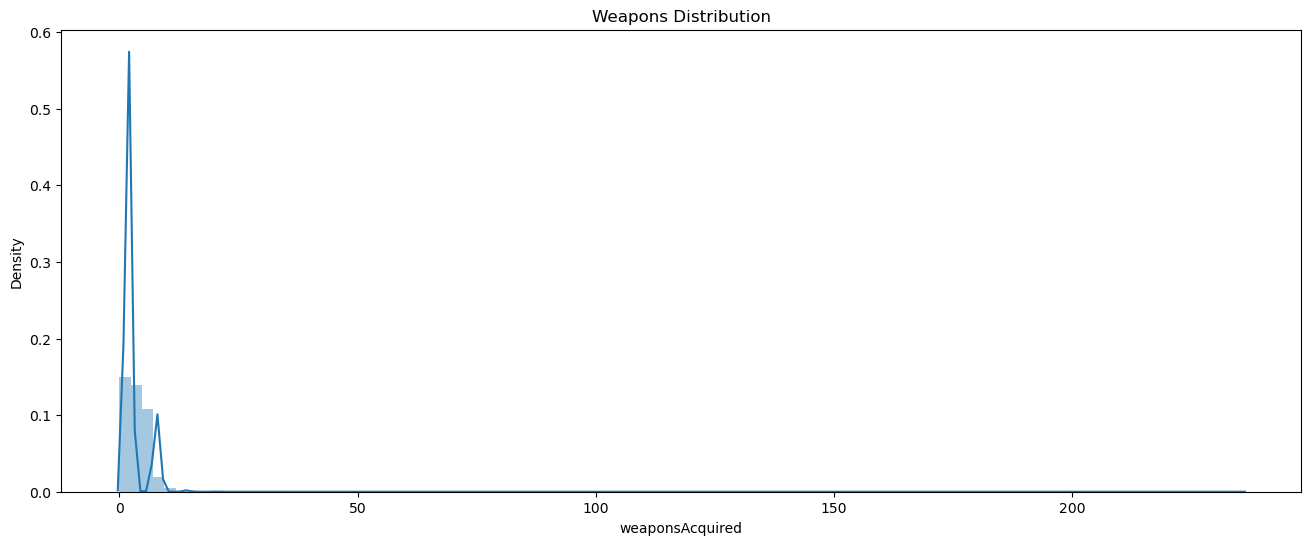

In [39]:
sns.distplot(df['weaponsAcquired'], bins=100).set_title("Weapons Distribution")
plt.show()

In [42]:
df[df["weaponsAcquired"]>=15].shape

(1374, 33)

In [43]:
df.drop(df[df["weaponsAcquired"]>=15].index, inplace = True)

## Exploratory Data Analysis

In [44]:
df.shape

(4436306, 33)

In [45]:
df.isna().sum() # there is no null values

Id                    0
groupId               0
matchId               0
assists               0
boosts                0
damageDealt           0
DBNOs                 0
headshotKills         0
heals                 0
killPlace             0
killPoints            0
kills                 0
killStreaks           0
longestKill           0
matchDuration         0
matchType             0
maxPlace              0
numGroups             0
rankPoints            0
revives               0
rideDistance          0
roadKills             0
swimDistance          0
teamKills             0
vehicleDestroys       0
walkDistance          0
weaponsAcquired       0
winPoints             0
winPlacePerc          0
playersJoined         0
TotalDistance         0
killswithoutMoving    0
headshot_rate         0
dtype: int64

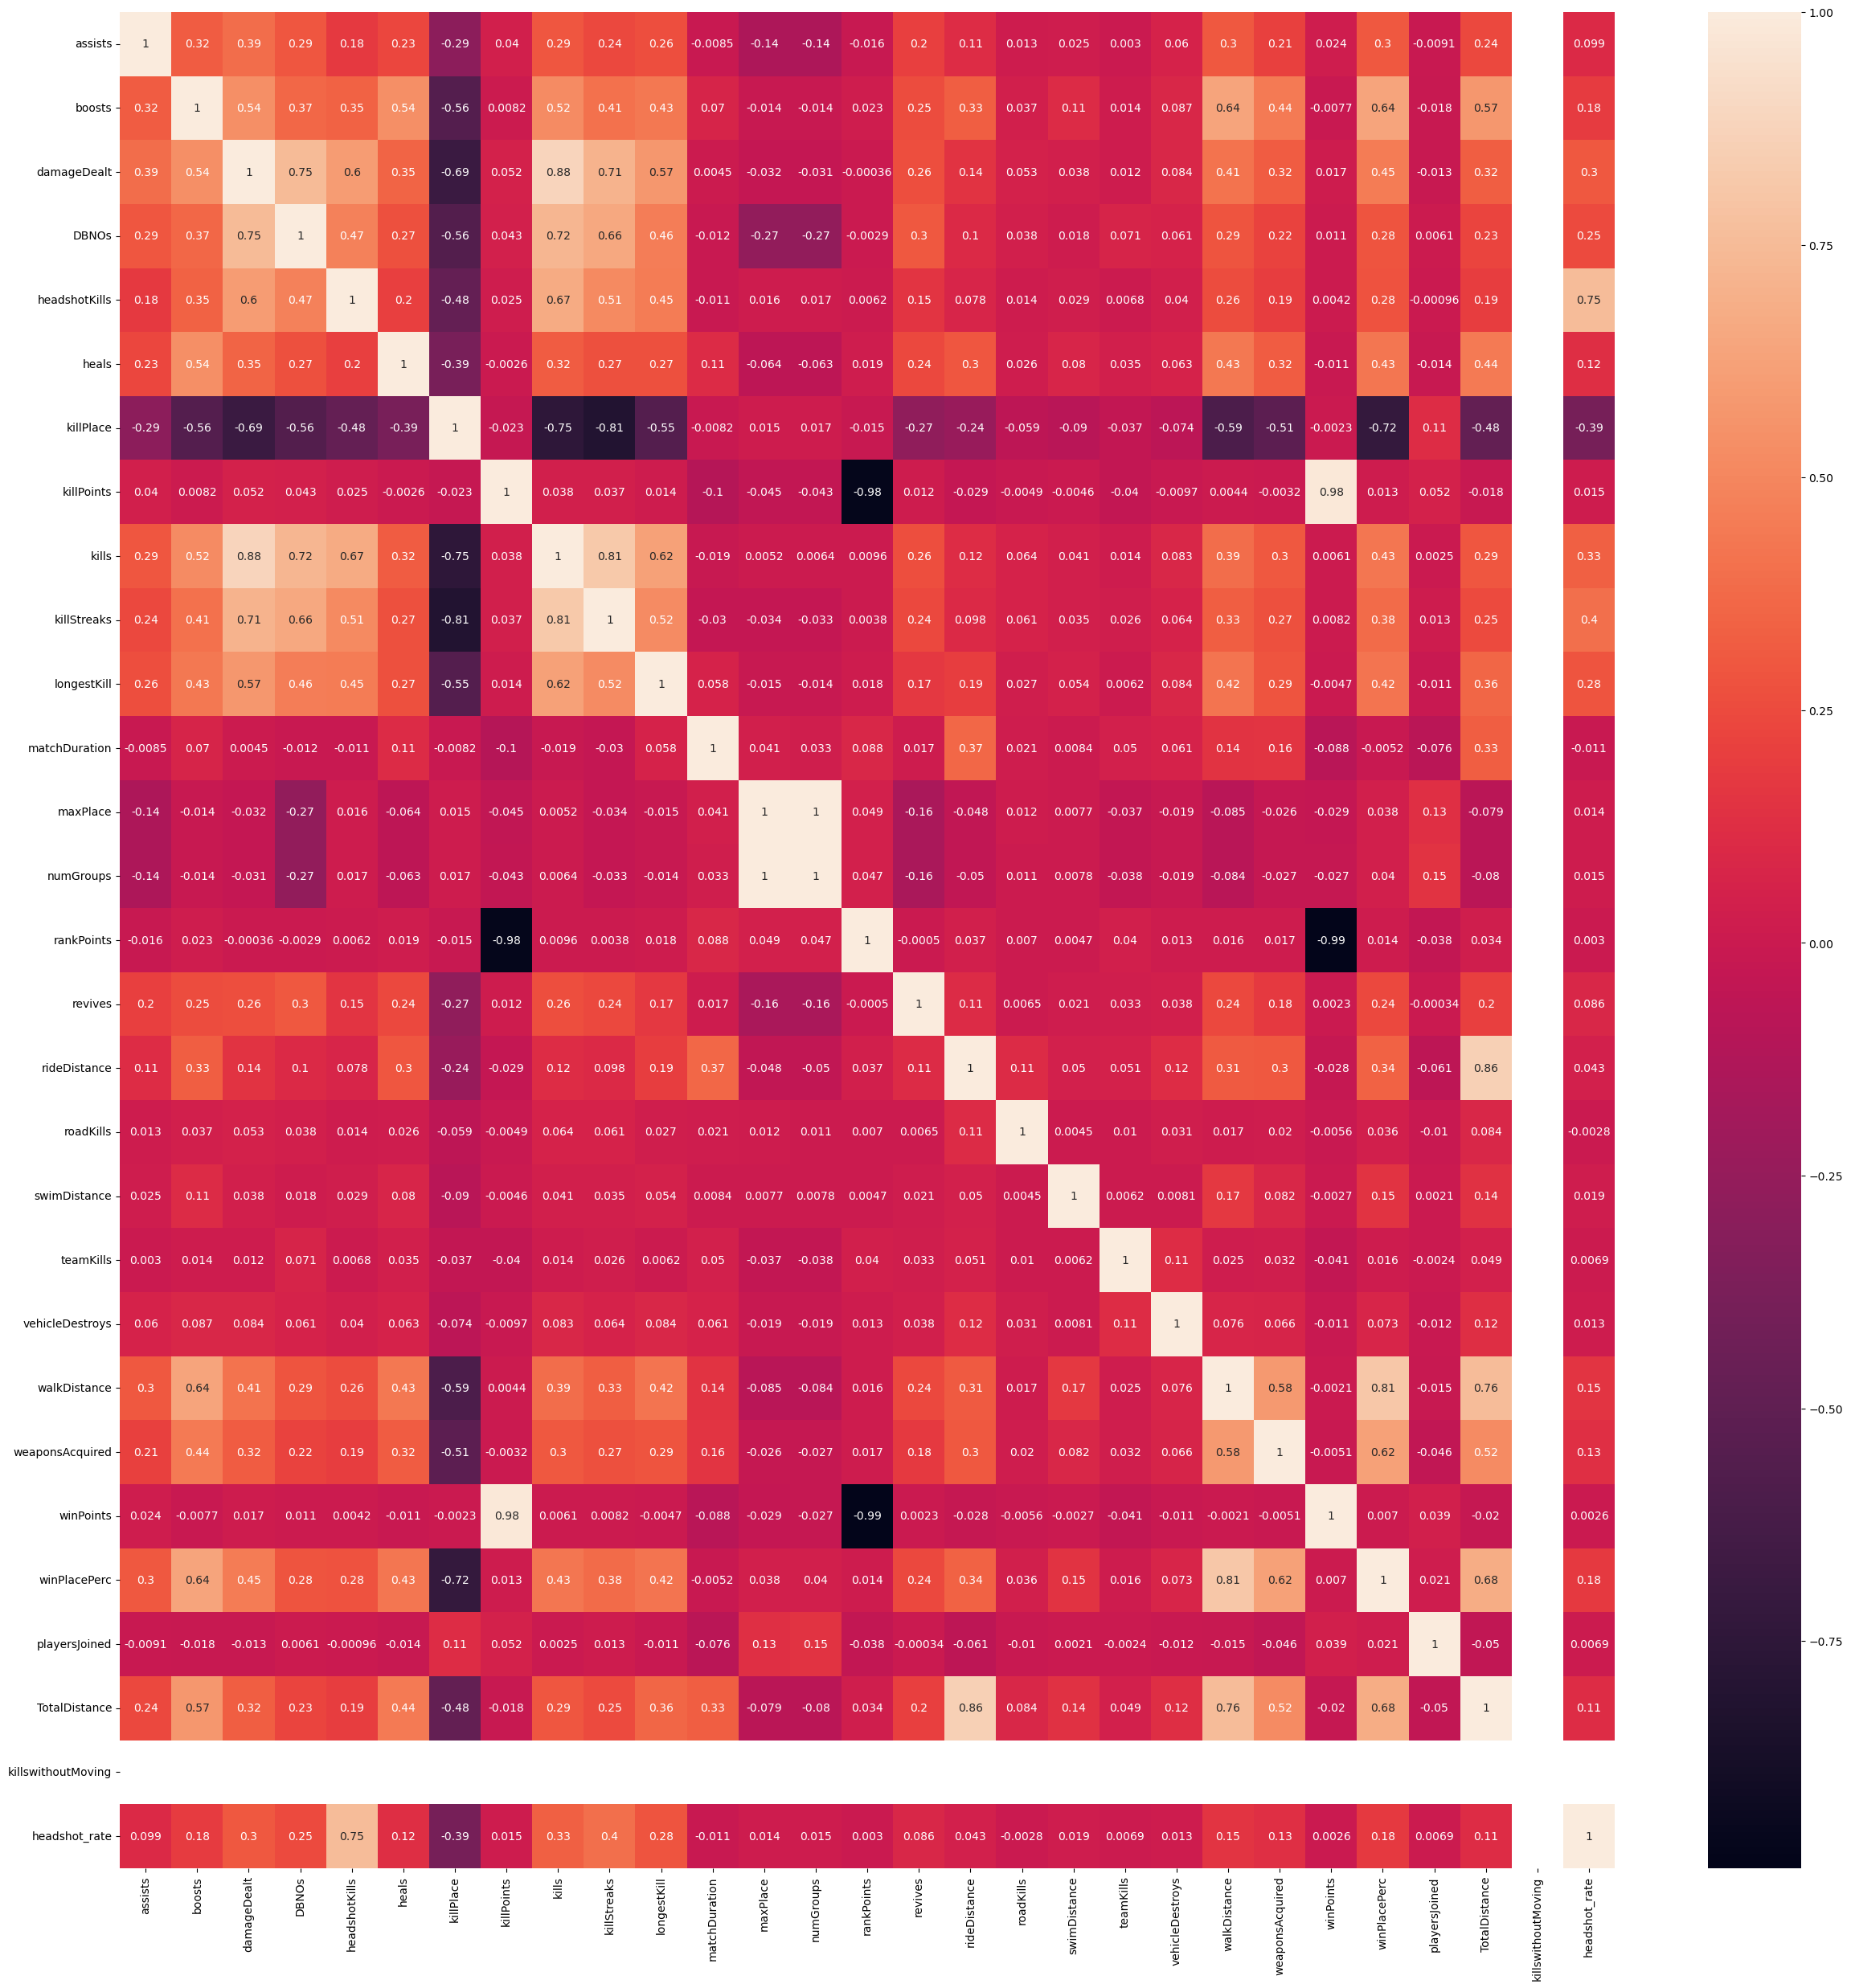

In [47]:
# correlation parameter with prediction
plt.figure(figsize=[30,30])
sns.heatmap(df.corr(), annot = True)
plt.show()

# <font color = "Green">Feature Engineering</font><a class = "anchor" id = "feature"></a>

In [55]:
# normalizing factor to normalize the data 
normalizing_factor = ((100 - df['playersJoined'])/100)+1
normalizing_factor

0          1.04
1          1.09
2          1.02
3          1.09
4          1.03
           ... 
4446961    1.06
4446962    1.07
4446963    1.02
4446964    1.06
4446965    1.02
Name: playersJoined, Length: 4436306, dtype: float64

In [53]:
df['killsNorm']       = df['kills'] * normalizing_factor
df['damageDealtNorm'] = df['damageDealt'] * normalizing_factor
df['maxPlaceNorm']    = df['maxPlace']* normalizing_factor
df['matchDurationNorm'] = df['matchDuration'] * normalizing_factor

df['traveldistance']  = df['TotalDistance'] 
df['healsboosts']     = df['heals'] + df['boosts']
df['assist']          = df['assists'] + df['revives'] 

In [54]:
df.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc', 'playersJoined',
       'TotalDistance', 'killswithoutMoving', 'headshot_rate', 'killsNorm',
       'damageDealtNorm', 'maxPlaceNorm', 'matchDurationNorm',
       'traveldistance', 'healsboosts', 'assist'],
      dtype='object')

In [58]:
data = df.drop(columns=['Id','groupId','matchId','assists','boosts','walkDistance','swimDistance','swimDistance','rideDistance',
                 'heals','revives','kills','damageDealt','maxPlace','matchDuration'])

In [59]:
data.head()

,DBNOs,headshotKills,killPlace,killPoints,killStreaks,longestKill,matchType,numGroups,rankPoints,roadKills,...,TotalDistance,killswithoutMoving,headshot_rate,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,traveldistance,healsboosts,assist
0,0,0,60,1241,0,0.00,squad-fpp,26,-1,0,...,244.8000,False,0.0,0.00,0.0000,2801.12,130652.24,244.8000,0,0
1,0,0,57,0,0,0.00,squad-fpp,25,1484,0,...,1445.0445,False,0.0,0.00,9155.2323,2602.34,177859.93,1445.0445,0,0
2,0,0,47,0,0,0.00,duo,47,1491,0,...,161.8000,False,0.0,0.00,6801.3600,5001.00,131826.36,161.8000,0,1
3,0,0,75,0,0,0.00,squad-fpp,30,1408,0,...,202.7000,False,0.0,0.00,3292.9610,3102.79,143729.24,202.7000,0,0
4,0,0,45,0,1,58.53,solo-fpp,95,1560,0,...,49.7500,False,0.0,100.03,10003.0000,9702.91,142442.72,49.7500,0,0


# <font color = "green">ML - Catboost Model</font><a class = "anchor" id = "cat"></a>

#### Handling categorical data

In [60]:
x = data.drop(['winPlacePerc'], axis =1)
y= data['winPlacePerc']

In [63]:
features

Index(['DBNOs', 'headshotKills', 'killPlace', 'killPoints', 'killStreaks',
       'longestKill', 'matchType', 'numGroups', 'rankPoints', 'roadKills',
       'teamKills', 'vehicleDestroys', 'weaponsAcquired', 'winPoints',
       'playersJoined', 'TotalDistance', 'killswithoutMoving', 'headshot_rate',
       'killsNorm', 'damageDealtNorm', 'maxPlaceNorm', 'matchDurationNorm',
       'traveldistance', 'healsboosts', 'assist'],
      dtype='object')

In [64]:
 x = pd.get_dummies(x, columns= ['matchType', 'killswithoutMoving']) 

In [65]:
x.head()

,DBNOs,headshotKills,killPlace,killPoints,killStreaks,longestKill,numGroups,rankPoints,roadKills,teamKills,...,matchType_normal-duo-fpp,matchType_normal-solo,matchType_normal-solo-fpp,matchType_normal-squad,matchType_normal-squad-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp,killswithoutMoving_False
0,0,0,60,1241,0,0.00,26,-1,0,0,...,0,0,0,0,0,0,0,0,1,1
1,0,0,57,0,0,0.00,25,1484,0,0,...,0,0,0,0,0,0,0,0,1,1
2,0,0,47,0,0,0.00,47,1491,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,75,0,0,0.00,30,1408,0,0,...,0,0,0,0,0,0,0,0,1,1
4,0,0,45,0,1,58.53,95,1560,0,0,...,0,0,0,0,0,0,1,0,0,1


In [67]:
data['matchType'].value_counts()

squad-fpp           1754750
duo-fpp              996013
squad                625317
solo-fpp             536223
duo                  313194
solo                 181460
normal-squad-fpp      13074
crashfpp               6274
normal-duo-fpp         5004
flaretpp               2497
normal-solo-fpp         845
flarefpp                717
crashtpp                367
normal-squad            305
normal-duo              144
normal-solo             122
Name: matchType, dtype: int64

In [68]:
x.shape

(4436306, 40)

In [69]:
features = x.columns

#### Scaling the data

In [70]:
sc = StandardScaler()
sc.fit(x)
x = pd.DataFrame(sc.transform(x))

In [71]:
x.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-0.582937,-0.384018,0.449345,1.172485,-0.765100,-0.459622,-0.732886,-1.212390,-0.049567,-0.142509,...,-0.033604,-0.005244,-0.013803,-0.008292,-0.054367,-0.206514,-0.370797,-0.405071,1.236192,0.0
1,-0.582937,-0.384018,0.340055,-0.804728,-0.765100,-0.459622,-0.775859,0.803564,-0.049567,-0.142509,...,-0.033604,-0.005244,-0.013803,-0.008292,-0.054367,-0.206514,-0.370797,-0.405071,1.236192,0.0
2,-0.582937,-0.384018,-0.024245,-0.804728,-0.765100,-0.459622,0.169557,0.813067,-0.049567,-0.142509,...,-0.033604,-0.005244,-0.013803,-0.008292,-0.054367,-0.206514,-0.370797,-0.405071,-0.808936,0.0
3,-0.582937,-0.384018,0.995795,-0.804728,-0.765100,-0.459622,-0.560992,0.700391,-0.049567,-0.142509,...,-0.033604,-0.005244,-0.013803,-0.008292,-0.054367,-0.206514,-0.370797,-0.405071,1.236192,0.0
4,-0.582937,-0.384018,-0.097105,-0.804728,0.647633,0.727371,2.232284,0.906738,-0.049567,-0.142509,...,-0.033604,-0.005244,-0.013803,-0.008292,-0.054367,-0.206514,2.696896,-0.405071,-0.808936,0.0


### Splitting data

In [72]:
xtrain , xtest, ytrain, ytest = train_test_split(x,y, test_size= 0.3 , random_state = 0)

In [73]:
print(xtrain.shape,ytrain.shape)
print(xtest.shape,ytest.shape)

(3105414, 40) (3105414,)
(1330892, 40) (1330892,)


## CatBoost Model

In [74]:
import catboost as cb 

In [75]:
train_dataset = cb.Pool(xtrain, ytrain)
test_dataset = cb.Pool(xtest, ytest)

In [76]:
model = cb.CatBoostRegressor(loss_function="RMSE")

In [78]:
# GRID Search

grid = {'iterations' : [100,150],
        'learning_rate': [0.03, 0.1],
        'depth' : [2,4,6,8]}
model.grid_search(grid, train_dataset)

0:	learn: 0.5482016	test: 0.5479886	best: 0.5479886 (0)	total: 238ms	remaining: 23.6s
1:	learn: 0.5333650	test: 0.5331566	best: 0.5331566 (1)	total: 287ms	remaining: 14s
2:	learn: 0.5189826	test: 0.5187815	best: 0.5187815 (2)	total: 332ms	remaining: 10.7s
3:	learn: 0.5050844	test: 0.5048926	best: 0.5048926 (3)	total: 376ms	remaining: 9.02s
4:	learn: 0.4916276	test: 0.4914432	best: 0.4914432 (4)	total: 420ms	remaining: 7.98s
5:	learn: 0.4786251	test: 0.4784449	best: 0.4784449 (5)	total: 466ms	remaining: 7.3s
6:	learn: 0.4660267	test: 0.4658539	best: 0.4658539 (6)	total: 512ms	remaining: 6.8s
7:	learn: 0.4538495	test: 0.4536820	best: 0.4536820 (7)	total: 556ms	remaining: 6.39s
8:	learn: 0.4420341	test: 0.4418693	best: 0.4418693 (8)	total: 603ms	remaining: 6.1s
9:	learn: 0.4306331	test: 0.4304748	best: 0.4304748 (9)	total: 648ms	remaining: 5.83s
10:	learn: 0.4195967	test: 0.4194453	best: 0.4194453 (10)	total: 693ms	remaining: 5.61s
11:	learn: 0.4089243	test: 0.4087765	best: 0.4087765 (11)

95:	learn: 0.1394478	test: 0.1395405	best: 0.1395405 (95)	total: 4.55s	remaining: 190ms
96:	learn: 0.1390753	test: 0.1391697	best: 0.1391697 (96)	total: 4.59s	remaining: 142ms
97:	learn: 0.1387199	test: 0.1388151	best: 0.1388151 (97)	total: 4.64s	remaining: 94.7ms
98:	learn: 0.1383766	test: 0.1384732	best: 0.1384732 (98)	total: 4.68s	remaining: 47.3ms
99:	learn: 0.1380397	test: 0.1381367	best: 0.1381367 (99)	total: 4.73s	remaining: 0us

bestTest = 0.1381366755
bestIteration = 99

0:	loss: 0.1381367	best: 0.1381367 (0)	total: 5.6s	remaining: 1m 23s
0:	learn: 0.5126068	test: 0.5124096	best: 0.5124096 (0)	total: 57.9ms	remaining: 5.73s
1:	learn: 0.4671679	test: 0.4669991	best: 0.4669991 (1)	total: 110ms	remaining: 5.39s
2:	learn: 0.4264429	test: 0.4262951	best: 0.4262951 (2)	total: 159ms	remaining: 5.15s
3:	learn: 0.3902182	test: 0.3900853	best: 0.3900853 (3)	total: 209ms	remaining: 5.01s
4:	learn: 0.3581625	test: 0.3580502	best: 0.3580502 (4)	total: 257ms	remaining: 4.87s
5:	learn: 0.329

88:	learn: 0.1174285	test: 0.1176647	best: 0.1176647 (88)	total: 3.95s	remaining: 488ms
89:	learn: 0.1171031	test: 0.1173483	best: 0.1173483 (89)	total: 3.99s	remaining: 444ms
90:	learn: 0.1170075	test: 0.1172519	best: 0.1172519 (90)	total: 4.03s	remaining: 399ms
91:	learn: 0.1169191	test: 0.1171636	best: 0.1171636 (91)	total: 4.08s	remaining: 354ms
92:	learn: 0.1168242	test: 0.1170669	best: 0.1170669 (92)	total: 4.12s	remaining: 310ms
93:	learn: 0.1167374	test: 0.1169829	best: 0.1169829 (93)	total: 4.16s	remaining: 265ms
94:	learn: 0.1166427	test: 0.1168850	best: 0.1168850 (94)	total: 4.2s	remaining: 221ms
95:	learn: 0.1165224	test: 0.1167628	best: 0.1167628 (95)	total: 4.24s	remaining: 177ms
96:	learn: 0.1164136	test: 0.1166544	best: 0.1166544 (96)	total: 4.28s	remaining: 132ms
97:	learn: 0.1163231	test: 0.1165631	best: 0.1165631 (97)	total: 4.32s	remaining: 88.2ms
98:	learn: 0.1162409	test: 0.1164784	best: 0.1164784 (98)	total: 4.36s	remaining: 44.1ms
99:	learn: 0.1161663	test: 0.11

82:	learn: 0.1459917	test: 0.1460750	best: 0.1460750 (82)	total: 3.74s	remaining: 3.02s
83:	learn: 0.1453945	test: 0.1454773	best: 0.1454773 (83)	total: 3.79s	remaining: 2.97s
84:	learn: 0.1448061	test: 0.1448892	best: 0.1448892 (84)	total: 3.83s	remaining: 2.93s
85:	learn: 0.1441889	test: 0.1442730	best: 0.1442730 (85)	total: 3.87s	remaining: 2.88s
86:	learn: 0.1436574	test: 0.1437424	best: 0.1437424 (86)	total: 3.92s	remaining: 2.84s
87:	learn: 0.1431242	test: 0.1432099	best: 0.1432099 (87)	total: 3.96s	remaining: 2.79s
88:	learn: 0.1425612	test: 0.1426476	best: 0.1426476 (88)	total: 4s	remaining: 2.74s
89:	learn: 0.1420826	test: 0.1421694	best: 0.1421694 (89)	total: 4.04s	remaining: 2.7s
90:	learn: 0.1416257	test: 0.1417131	best: 0.1417131 (90)	total: 4.09s	remaining: 2.65s
91:	learn: 0.1411888	test: 0.1412785	best: 0.1412785 (91)	total: 4.13s	remaining: 2.6s
92:	learn: 0.1407061	test: 0.1407970	best: 0.1407970 (92)	total: 4.18s	remaining: 2.56s
93:	learn: 0.1402872	test: 0.1403785	

25:	learn: 0.1428209	test: 0.1429318	best: 0.1429318 (25)	total: 1.18s	remaining: 5.62s
26:	learn: 0.1411019	test: 0.1412206	best: 0.1412206 (26)	total: 1.22s	remaining: 5.58s
27:	learn: 0.1397763	test: 0.1398917	best: 0.1398917 (27)	total: 1.27s	remaining: 5.52s
28:	learn: 0.1385976	test: 0.1387311	best: 0.1387311 (28)	total: 1.31s	remaining: 5.46s
29:	learn: 0.1374581	test: 0.1375932	best: 0.1375932 (29)	total: 1.35s	remaining: 5.41s
30:	learn: 0.1362990	test: 0.1364387	best: 0.1364387 (30)	total: 1.39s	remaining: 5.35s
31:	learn: 0.1354159	test: 0.1355534	best: 0.1355534 (31)	total: 1.43s	remaining: 5.29s
32:	learn: 0.1346504	test: 0.1347928	best: 0.1347928 (32)	total: 1.47s	remaining: 5.23s
33:	learn: 0.1337834	test: 0.1339284	best: 0.1339284 (33)	total: 1.52s	remaining: 5.18s
34:	learn: 0.1330728	test: 0.1332271	best: 0.1332271 (34)	total: 1.56s	remaining: 5.13s
35:	learn: 0.1324924	test: 0.1326522	best: 0.1326522 (35)	total: 1.6s	remaining: 5.07s
36:	learn: 0.1318372	test: 0.1320

122:	learn: 0.1132164	test: 0.1134445	best: 0.1134445 (122)	total: 5.28s	remaining: 1.16s
123:	learn: 0.1131634	test: 0.1133929	best: 0.1133929 (123)	total: 5.32s	remaining: 1.11s
124:	learn: 0.1128980	test: 0.1131247	best: 0.1131247 (124)	total: 5.36s	remaining: 1.07s
125:	learn: 0.1126908	test: 0.1129179	best: 0.1129179 (125)	total: 5.4s	remaining: 1.03s
126:	learn: 0.1125661	test: 0.1127893	best: 0.1127893 (126)	total: 5.45s	remaining: 986ms
127:	learn: 0.1122374	test: 0.1124655	best: 0.1124655 (127)	total: 5.49s	remaining: 944ms
128:	learn: 0.1121722	test: 0.1123991	best: 0.1123991 (128)	total: 5.53s	remaining: 901ms
129:	learn: 0.1121204	test: 0.1123445	best: 0.1123445 (129)	total: 5.57s	remaining: 857ms
130:	learn: 0.1120638	test: 0.1122876	best: 0.1122876 (130)	total: 5.61s	remaining: 814ms
131:	learn: 0.1120125	test: 0.1122356	best: 0.1122356 (131)	total: 5.65s	remaining: 771ms
132:	learn: 0.1119526	test: 0.1121757	best: 0.1121757 (132)	total: 5.69s	remaining: 728ms
133:	learn:

64:	learn: 0.1465855	test: 0.1467283	best: 0.1467283 (64)	total: 3.84s	remaining: 2.07s
65:	learn: 0.1451749	test: 0.1453197	best: 0.1453197 (65)	total: 3.9s	remaining: 2.01s
66:	learn: 0.1437990	test: 0.1439497	best: 0.1439497 (66)	total: 3.96s	remaining: 1.95s
67:	learn: 0.1425113	test: 0.1426640	best: 0.1426640 (67)	total: 4.02s	remaining: 1.89s
68:	learn: 0.1412931	test: 0.1414479	best: 0.1414479 (68)	total: 4.07s	remaining: 1.83s
69:	learn: 0.1401193	test: 0.1402762	best: 0.1402762 (69)	total: 4.13s	remaining: 1.77s
70:	learn: 0.1389903	test: 0.1391496	best: 0.1391496 (70)	total: 4.19s	remaining: 1.71s
71:	learn: 0.1379014	test: 0.1380643	best: 0.1380643 (71)	total: 4.24s	remaining: 1.65s
72:	learn: 0.1367989	test: 0.1369637	best: 0.1369637 (72)	total: 4.3s	remaining: 1.59s
73:	learn: 0.1358282	test: 0.1359968	best: 0.1359968 (73)	total: 4.36s	remaining: 1.53s
74:	learn: 0.1348494	test: 0.1350219	best: 0.1350219 (74)	total: 4.42s	remaining: 1.47s
75:	learn: 0.1337837	test: 0.13396

60:	learn: 0.1033076	test: 0.1035475	best: 0.1035475 (60)	total: 3.48s	remaining: 2.22s
61:	learn: 0.1031737	test: 0.1034118	best: 0.1034118 (61)	total: 3.53s	remaining: 2.16s
62:	learn: 0.1030069	test: 0.1032452	best: 0.1032452 (62)	total: 3.57s	remaining: 2.1s
63:	learn: 0.1026722	test: 0.1029110	best: 0.1029110 (63)	total: 3.63s	remaining: 2.04s
64:	learn: 0.1025396	test: 0.1027791	best: 0.1027791 (64)	total: 3.69s	remaining: 1.99s
65:	learn: 0.1021174	test: 0.1023578	best: 0.1023578 (65)	total: 3.75s	remaining: 1.93s
66:	learn: 0.1017887	test: 0.1020268	best: 0.1020268 (66)	total: 3.8s	remaining: 1.87s
67:	learn: 0.1015601	test: 0.1018014	best: 0.1018014 (67)	total: 3.85s	remaining: 1.81s
68:	learn: 0.1011897	test: 0.1014329	best: 0.1014329 (68)	total: 3.92s	remaining: 1.76s
69:	learn: 0.1008320	test: 0.1010809	best: 0.1010809 (69)	total: 3.98s	remaining: 1.7s
70:	learn: 0.1006166	test: 0.1008637	best: 0.1008637 (70)	total: 4.03s	remaining: 1.65s
71:	learn: 0.1004554	test: 0.100699

56:	learn: 0.1605638	test: 0.1606708	best: 0.1606708 (56)	total: 3.38s	remaining: 5.52s
57:	learn: 0.1585607	test: 0.1586720	best: 0.1586720 (57)	total: 3.44s	remaining: 5.46s
58:	learn: 0.1565743	test: 0.1566936	best: 0.1566936 (58)	total: 3.51s	remaining: 5.41s
59:	learn: 0.1547252	test: 0.1548482	best: 0.1548482 (59)	total: 3.56s	remaining: 5.34s
60:	learn: 0.1529240	test: 0.1530538	best: 0.1530538 (60)	total: 3.62s	remaining: 5.28s
61:	learn: 0.1512431	test: 0.1513749	best: 0.1513749 (61)	total: 3.68s	remaining: 5.22s
62:	learn: 0.1496426	test: 0.1497763	best: 0.1497763 (62)	total: 3.74s	remaining: 5.16s
63:	learn: 0.1480579	test: 0.1481975	best: 0.1481975 (63)	total: 3.79s	remaining: 5.1s
64:	learn: 0.1465855	test: 0.1467283	best: 0.1467283 (64)	total: 3.85s	remaining: 5.04s
65:	learn: 0.1451749	test: 0.1453197	best: 0.1453197 (65)	total: 3.91s	remaining: 4.97s
66:	learn: 0.1437990	test: 0.1439497	best: 0.1439497 (66)	total: 3.96s	remaining: 4.91s
67:	learn: 0.1425113	test: 0.1426

0:	learn: 0.5113966	test: 0.5112031	best: 0.5112031 (0)	total: 68.3ms	remaining: 10.2s
1:	learn: 0.4647505	test: 0.4645927	best: 0.4645927 (1)	total: 129ms	remaining: 9.54s
2:	learn: 0.4231629	test: 0.4230130	best: 0.4230130 (2)	total: 184ms	remaining: 9.03s
3:	learn: 0.3858956	test: 0.3857805	best: 0.3857805 (3)	total: 242ms	remaining: 8.81s
4:	learn: 0.3528517	test: 0.3527539	best: 0.3527539 (4)	total: 300ms	remaining: 8.7s
5:	learn: 0.3234699	test: 0.3233862	best: 0.3233862 (5)	total: 356ms	remaining: 8.55s
6:	learn: 0.2974050	test: 0.2973430	best: 0.2973430 (6)	total: 413ms	remaining: 8.43s
7:	learn: 0.2742515	test: 0.2742057	best: 0.2742057 (7)	total: 472ms	remaining: 8.38s
8:	learn: 0.2537239	test: 0.2536933	best: 0.2536933 (8)	total: 533ms	remaining: 8.35s
9:	learn: 0.2355907	test: 0.2355830	best: 0.2355830 (9)	total: 593ms	remaining: 8.31s
10:	learn: 0.2193219	test: 0.2193430	best: 0.2193430 (10)	total: 654ms	remaining: 8.26s
11:	learn: 0.2053915	test: 0.2054211	best: 0.2054211

96:	learn: 0.0959571	test: 0.0961689	best: 0.0961689 (96)	total: 5.51s	remaining: 3.01s
97:	learn: 0.0958325	test: 0.0960460	best: 0.0960460 (97)	total: 5.57s	remaining: 2.96s
98:	learn: 0.0957390	test: 0.0959458	best: 0.0959458 (98)	total: 5.63s	remaining: 2.9s
99:	learn: 0.0956662	test: 0.0958732	best: 0.0958732 (99)	total: 5.68s	remaining: 2.84s
100:	learn: 0.0955498	test: 0.0957578	best: 0.0957578 (100)	total: 5.73s	remaining: 2.78s
101:	learn: 0.0954380	test: 0.0956469	best: 0.0956469 (101)	total: 5.79s	remaining: 2.72s
102:	learn: 0.0952881	test: 0.0954938	best: 0.0954938 (102)	total: 5.84s	remaining: 2.66s
103:	learn: 0.0952028	test: 0.0954082	best: 0.0954082 (103)	total: 5.89s	remaining: 2.6s
104:	learn: 0.0951197	test: 0.0953249	best: 0.0953249 (104)	total: 5.94s	remaining: 2.55s
105:	learn: 0.0949958	test: 0.0952026	best: 0.0952026 (105)	total: 6s	remaining: 2.49s
106:	learn: 0.0949451	test: 0.0951476	best: 0.0951476 (106)	total: 6.05s	remaining: 2.43s
107:	learn: 0.0947659	t

39:	learn: 0.2039430	test: 0.2040193	best: 0.2040193 (39)	total: 3.47s	remaining: 5.21s
40:	learn: 0.1998949	test: 0.1999769	best: 0.1999769 (40)	total: 3.56s	remaining: 5.12s
41:	learn: 0.1959356	test: 0.1960220	best: 0.1960220 (41)	total: 3.65s	remaining: 5.04s
42:	learn: 0.1921730	test: 0.1922662	best: 0.1922662 (42)	total: 3.74s	remaining: 4.95s
43:	learn: 0.1885496	test: 0.1886470	best: 0.1886470 (43)	total: 3.82s	remaining: 4.87s
44:	learn: 0.1850447	test: 0.1851463	best: 0.1851463 (44)	total: 3.91s	remaining: 4.78s
45:	learn: 0.1816380	test: 0.1817466	best: 0.1817466 (45)	total: 4s	remaining: 4.7s
46:	learn: 0.1784062	test: 0.1785220	best: 0.1785220 (46)	total: 4.1s	remaining: 4.62s
47:	learn: 0.1752904	test: 0.1754097	best: 0.1754097 (47)	total: 4.19s	remaining: 4.54s
48:	learn: 0.1723073	test: 0.1724304	best: 0.1724304 (48)	total: 4.29s	remaining: 4.46s
49:	learn: 0.1694476	test: 0.1695731	best: 0.1695731 (49)	total: 4.38s	remaining: 4.38s
50:	learn: 0.1666398	test: 0.1667717	

33:	learn: 0.1044396	test: 0.1047092	best: 0.1047092 (33)	total: 2.54s	remaining: 4.94s
34:	learn: 0.1036130	test: 0.1038823	best: 0.1038823 (34)	total: 2.62s	remaining: 4.86s
35:	learn: 0.1024720	test: 0.1027304	best: 0.1027304 (35)	total: 2.69s	remaining: 4.78s
36:	learn: 0.1017520	test: 0.1020036	best: 0.1020036 (36)	total: 2.77s	remaining: 4.71s
37:	learn: 0.1012202	test: 0.1014680	best: 0.1014680 (37)	total: 2.84s	remaining: 4.63s
38:	learn: 0.1004476	test: 0.1006920	best: 0.1006920 (38)	total: 2.91s	remaining: 4.55s
39:	learn: 0.1000889	test: 0.1003335	best: 0.1003335 (39)	total: 2.97s	remaining: 4.46s
40:	learn: 0.0995718	test: 0.0998175	best: 0.0998175 (40)	total: 3.04s	remaining: 4.38s
41:	learn: 0.0991263	test: 0.0993770	best: 0.0993770 (41)	total: 3.11s	remaining: 4.3s
42:	learn: 0.0988512	test: 0.0991016	best: 0.0991016 (42)	total: 3.18s	remaining: 4.21s
43:	learn: 0.0984001	test: 0.0986402	best: 0.0986402 (43)	total: 3.24s	remaining: 4.13s
44:	learn: 0.0980017	test: 0.0982

27:	learn: 0.2664793	test: 0.2664859	best: 0.2664859 (27)	total: 2.08s	remaining: 9.07s
28:	learn: 0.2601959	test: 0.2602075	best: 0.2602075 (28)	total: 2.16s	remaining: 9s
29:	learn: 0.2541062	test: 0.2541259	best: 0.2541259 (29)	total: 2.23s	remaining: 8.93s
30:	learn: 0.2482311	test: 0.2482559	best: 0.2482559 (30)	total: 2.31s	remaining: 8.85s
31:	learn: 0.2425636	test: 0.2425949	best: 0.2425949 (31)	total: 2.38s	remaining: 8.78s
32:	learn: 0.2371181	test: 0.2371546	best: 0.2371546 (32)	total: 2.45s	remaining: 8.7s
33:	learn: 0.2318326	test: 0.2318775	best: 0.2318775 (33)	total: 2.53s	remaining: 8.63s
34:	learn: 0.2267477	test: 0.2267978	best: 0.2267978 (34)	total: 2.6s	remaining: 8.56s
35:	learn: 0.2218379	test: 0.2218938	best: 0.2218938 (35)	total: 2.68s	remaining: 8.48s
36:	learn: 0.2170756	test: 0.2171393	best: 0.2171393 (36)	total: 2.76s	remaining: 8.42s
37:	learn: 0.2125406	test: 0.2126089	best: 0.2126089 (37)	total: 2.83s	remaining: 8.34s
38:	learn: 0.2081432	test: 0.2082160	

121:	learn: 0.1030993	test: 0.1033240	best: 0.1033240 (121)	total: 8.93s	remaining: 2.05s
122:	learn: 0.1027857	test: 0.1030093	best: 0.1030093 (122)	total: 9s	remaining: 1.98s
123:	learn: 0.1025973	test: 0.1028212	best: 0.1028212 (123)	total: 9.07s	remaining: 1.9s
124:	learn: 0.1024456	test: 0.1026696	best: 0.1026696 (124)	total: 9.14s	remaining: 1.83s
125:	learn: 0.1022815	test: 0.1025057	best: 0.1025057 (125)	total: 9.21s	remaining: 1.75s
126:	learn: 0.1019744	test: 0.1021938	best: 0.1021938 (126)	total: 9.28s	remaining: 1.68s
127:	learn: 0.1017645	test: 0.1019829	best: 0.1019829 (127)	total: 9.36s	remaining: 1.61s
128:	learn: 0.1016143	test: 0.1018339	best: 0.1018339 (128)	total: 9.42s	remaining: 1.53s
129:	learn: 0.1014793	test: 0.1016985	best: 0.1016985 (129)	total: 9.49s	remaining: 1.46s
130:	learn: 0.1013469	test: 0.1015663	best: 0.1015663 (130)	total: 9.56s	remaining: 1.39s
131:	learn: 0.1011853	test: 0.1014037	best: 0.1014037 (131)	total: 9.62s	remaining: 1.31s
132:	learn: 0.

64:	learn: 0.0923511	test: 0.0925461	best: 0.0925461 (64)	total: 4.79s	remaining: 6.26s
65:	learn: 0.0921799	test: 0.0923731	best: 0.0923731 (65)	total: 4.85s	remaining: 6.17s
66:	learn: 0.0920377	test: 0.0922222	best: 0.0922222 (66)	total: 4.92s	remaining: 6.09s
67:	learn: 0.0918678	test: 0.0920523	best: 0.0920523 (67)	total: 4.99s	remaining: 6.01s
68:	learn: 0.0917484	test: 0.0919349	best: 0.0919349 (68)	total: 5.05s	remaining: 5.93s
69:	learn: 0.0915755	test: 0.0917622	best: 0.0917622 (69)	total: 5.12s	remaining: 5.85s
70:	learn: 0.0914326	test: 0.0916193	best: 0.0916193 (70)	total: 5.19s	remaining: 5.77s
71:	learn: 0.0912434	test: 0.0914323	best: 0.0914323 (71)	total: 5.25s	remaining: 5.69s
72:	learn: 0.0911240	test: 0.0913081	best: 0.0913081 (72)	total: 5.31s	remaining: 5.6s
73:	learn: 0.0908819	test: 0.0910669	best: 0.0910669 (73)	total: 5.37s	remaining: 5.52s
74:	learn: 0.0907558	test: 0.0909393	best: 0.0909393 (74)	total: 5.44s	remaining: 5.44s
75:	learn: 0.0906268	test: 0.0908

6:	learn: 0.4615779	test: 0.4614225	best: 0.4614225 (6)	total: 658ms	remaining: 8.74s
7:	learn: 0.4487708	test: 0.4486231	best: 0.4486231 (7)	total: 752ms	remaining: 8.65s
8:	learn: 0.4363353	test: 0.4361986	best: 0.4361986 (8)	total: 847ms	remaining: 8.56s
9:	learn: 0.4243002	test: 0.4241707	best: 0.4241707 (9)	total: 940ms	remaining: 8.46s
10:	learn: 0.4126520	test: 0.4125320	best: 0.4125320 (10)	total: 1.02s	remaining: 8.3s
11:	learn: 0.4013852	test: 0.4012716	best: 0.4012716 (11)	total: 1.12s	remaining: 8.21s
12:	learn: 0.3904571	test: 0.3903538	best: 0.3903538 (12)	total: 1.21s	remaining: 8.13s
13:	learn: 0.3799066	test: 0.3798130	best: 0.3798130 (13)	total: 1.31s	remaining: 8.04s
14:	learn: 0.3697188	test: 0.3696317	best: 0.3696317 (14)	total: 1.41s	remaining: 7.97s
15:	learn: 0.3598392	test: 0.3597583	best: 0.3597583 (15)	total: 1.51s	remaining: 7.95s
16:	learn: 0.3502343	test: 0.3501634	best: 0.3501634 (16)	total: 1.6s	remaining: 7.82s
17:	learn: 0.3409696	test: 0.3409090	best:

0:	learn: 0.5104780	test: 0.5102899	best: 0.5102899 (0)	total: 114ms	remaining: 11.3s
1:	learn: 0.4627962	test: 0.4626367	best: 0.4626367 (1)	total: 224ms	remaining: 11s
2:	learn: 0.4201737	test: 0.4200439	best: 0.4200439 (2)	total: 329ms	remaining: 10.6s
3:	learn: 0.3818682	test: 0.3817559	best: 0.3817559 (3)	total: 443ms	remaining: 10.6s
4:	learn: 0.3477825	test: 0.3476988	best: 0.3476988 (4)	total: 545ms	remaining: 10.4s
5:	learn: 0.3172513	test: 0.3172003	best: 0.3172003 (5)	total: 645ms	remaining: 10.1s
6:	learn: 0.2901033	test: 0.2900797	best: 0.2900797 (6)	total: 737ms	remaining: 9.8s
7:	learn: 0.2658309	test: 0.2658314	best: 0.2658314 (7)	total: 835ms	remaining: 9.6s
8:	learn: 0.2444552	test: 0.2444777	best: 0.2444777 (8)	total: 929ms	remaining: 9.39s
9:	learn: 0.2253355	test: 0.2253853	best: 0.2253853 (9)	total: 1.03s	remaining: 9.26s
10:	learn: 0.2085713	test: 0.2086461	best: 0.2086461 (10)	total: 1.13s	remaining: 9.14s
11:	learn: 0.1935384	test: 0.1936317	best: 0.1936317 (11

94:	learn: 0.0845629	test: 0.0847684	best: 0.0847684 (94)	total: 8.63s	remaining: 454ms
95:	learn: 0.0844903	test: 0.0846995	best: 0.0846995 (95)	total: 8.72s	remaining: 363ms
96:	learn: 0.0843817	test: 0.0845920	best: 0.0845920 (96)	total: 8.81s	remaining: 272ms
97:	learn: 0.0843059	test: 0.0845171	best: 0.0845171 (97)	total: 8.9s	remaining: 182ms
98:	learn: 0.0842346	test: 0.0844450	best: 0.0844450 (98)	total: 8.99s	remaining: 90.8ms
99:	learn: 0.0841723	test: 0.0843832	best: 0.0843832 (99)	total: 9.06s	remaining: 0us

bestTest = 0.08438324263
bestIteration = 99

13:	loss: 0.0843832	best: 0.0843832 (13)	total: 1m 49s	remaining: 15.6s
0:	learn: 0.5475834	test: 0.5473730	best: 0.5473730 (0)	total: 102ms	remaining: 15.3s
1:	learn: 0.5320795	test: 0.5318759	best: 0.5318759 (1)	total: 205ms	remaining: 15.1s
2:	learn: 0.5170910	test: 0.5168972	best: 0.5168972 (2)	total: 300ms	remaining: 14.7s
3:	learn: 0.5025390	test: 0.5023532	best: 0.5023532 (3)	total: 390ms	remaining: 14.2s
4:	learn: 0.

87:	learn: 0.1077460	test: 0.1079831	best: 0.1079831 (87)	total: 8.03s	remaining: 5.66s
88:	learn: 0.1071269	test: 0.1073627	best: 0.1073627 (88)	total: 8.12s	remaining: 5.56s
89:	learn: 0.1066098	test: 0.1068455	best: 0.1068455 (89)	total: 8.2s	remaining: 5.47s
90:	learn: 0.1060513	test: 0.1062879	best: 0.1062879 (90)	total: 8.29s	remaining: 5.37s
91:	learn: 0.1055216	test: 0.1057572	best: 0.1057572 (91)	total: 8.38s	remaining: 5.29s
92:	learn: 0.1050588	test: 0.1052952	best: 0.1052952 (92)	total: 8.47s	remaining: 5.19s
93:	learn: 0.1046189	test: 0.1048562	best: 0.1048562 (93)	total: 8.54s	remaining: 5.09s
94:	learn: 0.1041491	test: 0.1043859	best: 0.1043859 (94)	total: 8.64s	remaining: 5s
95:	learn: 0.1037359	test: 0.1039745	best: 0.1039745 (95)	total: 8.73s	remaining: 4.91s
96:	learn: 0.1032998	test: 0.1035371	best: 0.1035371 (96)	total: 8.81s	remaining: 4.82s
97:	learn: 0.1028712	test: 0.1031091	best: 0.1031091 (97)	total: 8.91s	remaining: 4.72s
98:	learn: 0.1024582	test: 0.1026965

30:	learn: 0.0999280	test: 0.1001645	best: 0.1001645 (30)	total: 2.88s	remaining: 11.1s
31:	learn: 0.0991218	test: 0.0993622	best: 0.0993622 (31)	total: 2.96s	remaining: 10.9s
32:	learn: 0.0983906	test: 0.0986320	best: 0.0986320 (32)	total: 3.04s	remaining: 10.8s
33:	learn: 0.0976333	test: 0.0978802	best: 0.0978802 (33)	total: 3.13s	remaining: 10.7s
34:	learn: 0.0968895	test: 0.0971385	best: 0.0971385 (34)	total: 3.21s	remaining: 10.5s
35:	learn: 0.0962905	test: 0.0965403	best: 0.0965403 (35)	total: 3.31s	remaining: 10.5s
36:	learn: 0.0956619	test: 0.0959128	best: 0.0959128 (36)	total: 3.39s	remaining: 10.3s
37:	learn: 0.0951351	test: 0.0953793	best: 0.0953793 (37)	total: 3.48s	remaining: 10.3s
38:	learn: 0.0946805	test: 0.0949228	best: 0.0949228 (38)	total: 3.56s	remaining: 10.1s
39:	learn: 0.0942659	test: 0.0945125	best: 0.0945125 (39)	total: 3.64s	remaining: 10s
40:	learn: 0.0937599	test: 0.0940113	best: 0.0940113 (40)	total: 3.72s	remaining: 9.9s
41:	learn: 0.0934332	test: 0.093681

123:	learn: 0.0829492	test: 0.0831743	best: 0.0831743 (123)	total: 10.7s	remaining: 2.24s
124:	learn: 0.0829191	test: 0.0831437	best: 0.0831437 (124)	total: 10.8s	remaining: 2.16s
125:	learn: 0.0828930	test: 0.0831181	best: 0.0831181 (125)	total: 10.9s	remaining: 2.07s
126:	learn: 0.0828707	test: 0.0830969	best: 0.0830969 (126)	total: 10.9s	remaining: 1.98s
127:	learn: 0.0828370	test: 0.0830635	best: 0.0830635 (127)	total: 11s	remaining: 1.9s
128:	learn: 0.0828125	test: 0.0830398	best: 0.0830398 (128)	total: 11.1s	remaining: 1.81s
129:	learn: 0.0827827	test: 0.0830100	best: 0.0830100 (129)	total: 11.2s	remaining: 1.72s
130:	learn: 0.0827511	test: 0.0829791	best: 0.0829791 (130)	total: 11.3s	remaining: 1.63s
131:	learn: 0.0827227	test: 0.0829518	best: 0.0829518 (131)	total: 11.3s	remaining: 1.55s
132:	learn: 0.0826930	test: 0.0829209	best: 0.0829209 (132)	total: 11.4s	remaining: 1.46s
133:	learn: 0.0826778	test: 0.0829055	best: 0.0829055 (133)	total: 11.5s	remaining: 1.37s
134:	learn: 0

67:	learn: 0.0871520	test: 0.0872467	best: 0.0872467 (67)	total: 5.16s	remaining: 6.22s
68:	learn: 0.0869916	test: 0.0870889	best: 0.0870889 (68)	total: 5.22s	remaining: 6.13s
69:	learn: 0.0868193	test: 0.0869164	best: 0.0869164 (69)	total: 5.3s	remaining: 6.05s
70:	learn: 0.0867167	test: 0.0868191	best: 0.0868191 (70)	total: 5.37s	remaining: 5.97s
71:	learn: 0.0866276	test: 0.0867343	best: 0.0867343 (71)	total: 5.44s	remaining: 5.89s
72:	learn: 0.0865316	test: 0.0866380	best: 0.0866380 (72)	total: 5.51s	remaining: 5.81s
73:	learn: 0.0864246	test: 0.0865307	best: 0.0865307 (73)	total: 5.58s	remaining: 5.73s
74:	learn: 0.0863076	test: 0.0864144	best: 0.0864144 (74)	total: 5.66s	remaining: 5.66s
75:	learn: 0.0861941	test: 0.0863063	best: 0.0863063 (75)	total: 5.72s	remaining: 5.57s
76:	learn: 0.0860416	test: 0.0861537	best: 0.0861537 (76)	total: 5.8s	remaining: 5.5s
77:	learn: 0.0859647	test: 0.0860757	best: 0.0860757 (77)	total: 5.86s	remaining: 5.41s
78:	learn: 0.0858495	test: 0.085962

9:	learn: 0.2253427	test: 0.2254153	best: 0.2254153 (9)	total: 806ms	remaining: 11.3s
10:	learn: 0.2083393	test: 0.2084176	best: 0.2084176 (10)	total: 885ms	remaining: 11.2s
11:	learn: 0.1934477	test: 0.1935201	best: 0.1935201 (11)	total: 959ms	remaining: 11s
12:	learn: 0.1804488	test: 0.1805215	best: 0.1805215 (12)	total: 1.04s	remaining: 10.9s
13:	learn: 0.1689415	test: 0.1690122	best: 0.1690122 (13)	total: 1.11s	remaining: 10.8s
14:	learn: 0.1588592	test: 0.1589328	best: 0.1589328 (14)	total: 1.19s	remaining: 10.7s
15:	learn: 0.1500887	test: 0.1501749	best: 0.1501749 (15)	total: 1.27s	remaining: 10.6s
16:	learn: 0.1425061	test: 0.1426035	best: 0.1426035 (16)	total: 1.35s	remaining: 10.6s
17:	learn: 0.1360119	test: 0.1361181	best: 0.1361181 (17)	total: 1.43s	remaining: 10.5s
18:	learn: 0.1301007	test: 0.1302134	best: 0.1302134 (18)	total: 1.51s	remaining: 10.4s
19:	learn: 0.1252613	test: 0.1253720	best: 0.1253720 (19)	total: 1.58s	remaining: 10.3s
20:	learn: 0.1209776	test: 0.1210903

104:	learn: 0.0837262	test: 0.0839624	best: 0.0839624 (104)	total: 7.87s	remaining: 3.37s
105:	learn: 0.0836859	test: 0.0839228	best: 0.0839228 (105)	total: 7.93s	remaining: 3.29s
106:	learn: 0.0836334	test: 0.0838744	best: 0.0838744 (106)	total: 8s	remaining: 3.22s
107:	learn: 0.0835923	test: 0.0838335	best: 0.0838335 (107)	total: 8.07s	remaining: 3.14s
108:	learn: 0.0835091	test: 0.0837516	best: 0.0837516 (108)	total: 8.14s	remaining: 3.06s
109:	learn: 0.0834605	test: 0.0837040	best: 0.0837040 (109)	total: 8.21s	remaining: 2.99s
110:	learn: 0.0834038	test: 0.0836505	best: 0.0836505 (110)	total: 8.31s	remaining: 2.92s
111:	learn: 0.0833633	test: 0.0836103	best: 0.0836103 (111)	total: 8.37s	remaining: 2.84s
112:	learn: 0.0833084	test: 0.0835555	best: 0.0835555 (112)	total: 8.44s	remaining: 2.76s
113:	learn: 0.0832563	test: 0.0835051	best: 0.0835051 (113)	total: 8.51s	remaining: 2.69s
114:	learn: 0.0832152	test: 0.0834687	best: 0.0834687 (114)	total: 8.58s	remaining: 2.61s
115:	learn: 0

48:	learn: 0.0906231	test: 0.0905383	best: 0.0905383 (48)	total: 3.76s	remaining: 7.75s
49:	learn: 0.0903592	test: 0.0902674	best: 0.0902674 (49)	total: 3.86s	remaining: 7.71s
50:	learn: 0.0900952	test: 0.0900070	best: 0.0900070 (50)	total: 3.95s	remaining: 7.67s
51:	learn: 0.0899347	test: 0.0898443	best: 0.0898443 (51)	total: 4.02s	remaining: 7.58s
52:	learn: 0.0897597	test: 0.0896714	best: 0.0896714 (52)	total: 4.1s	remaining: 7.5s
53:	learn: 0.0895895	test: 0.0895012	best: 0.0895012 (53)	total: 4.18s	remaining: 7.42s
54:	learn: 0.0893084	test: 0.0892228	best: 0.0892228 (54)	total: 4.25s	remaining: 7.35s
55:	learn: 0.0890308	test: 0.0889466	best: 0.0889466 (55)	total: 4.34s	remaining: 7.28s
56:	learn: 0.0888992	test: 0.0888152	best: 0.0888152 (56)	total: 4.42s	remaining: 7.21s
57:	learn: 0.0887439	test: 0.0886602	best: 0.0886602 (57)	total: 4.5s	remaining: 7.14s
58:	learn: 0.0885954	test: 0.0885118	best: 0.0885118 (58)	total: 4.57s	remaining: 7.06s
59:	learn: 0.0883721	test: 0.088291

143:	learn: 0.0824039	test: 0.0823826	best: 0.0823826 (143)	total: 11s	remaining: 459ms
144:	learn: 0.0823775	test: 0.0823572	best: 0.0823572 (144)	total: 11.1s	remaining: 382ms
145:	learn: 0.0823365	test: 0.0823144	best: 0.0823144 (145)	total: 11.2s	remaining: 305ms
146:	learn: 0.0823135	test: 0.0822918	best: 0.0822918 (146)	total: 11.2s	remaining: 229ms
147:	learn: 0.0822985	test: 0.0822770	best: 0.0822770 (147)	total: 11.3s	remaining: 153ms
148:	learn: 0.0822629	test: 0.0822435	best: 0.0822435 (148)	total: 11.4s	remaining: 76.3ms
149:	learn: 0.0822164	test: 0.0822009	best: 0.0822009 (149)	total: 11.4s	remaining: 0us

bestTest = 0.08220093403
bestIteration = 149



{'params': {'depth': 8, 'learning_rate': 0.1, 'iterations': 150},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
    

In [79]:
feature_importance_df = pd.DataFrame()
feature_importance_df['features'] = features
feature_importance_df['importance'] = model.feature_importances_

feature_importance_df = feature_importance_df.sort_values(by = ['importance'], ascending = False)

In [80]:
feature_importance_df

,features,importance
2,killPlace,40.804634
14,TotalDistance,12.507865
20,traveldistance,11.786296
16,killsNorm,7.596194
4,killStreaks,7.568429
19,matchDurationNorm,5.355363
13,playersJoined,4.684276
6,numGroups,2.265490
21,healsboosts,1.830046
5,longestKill,1.805096


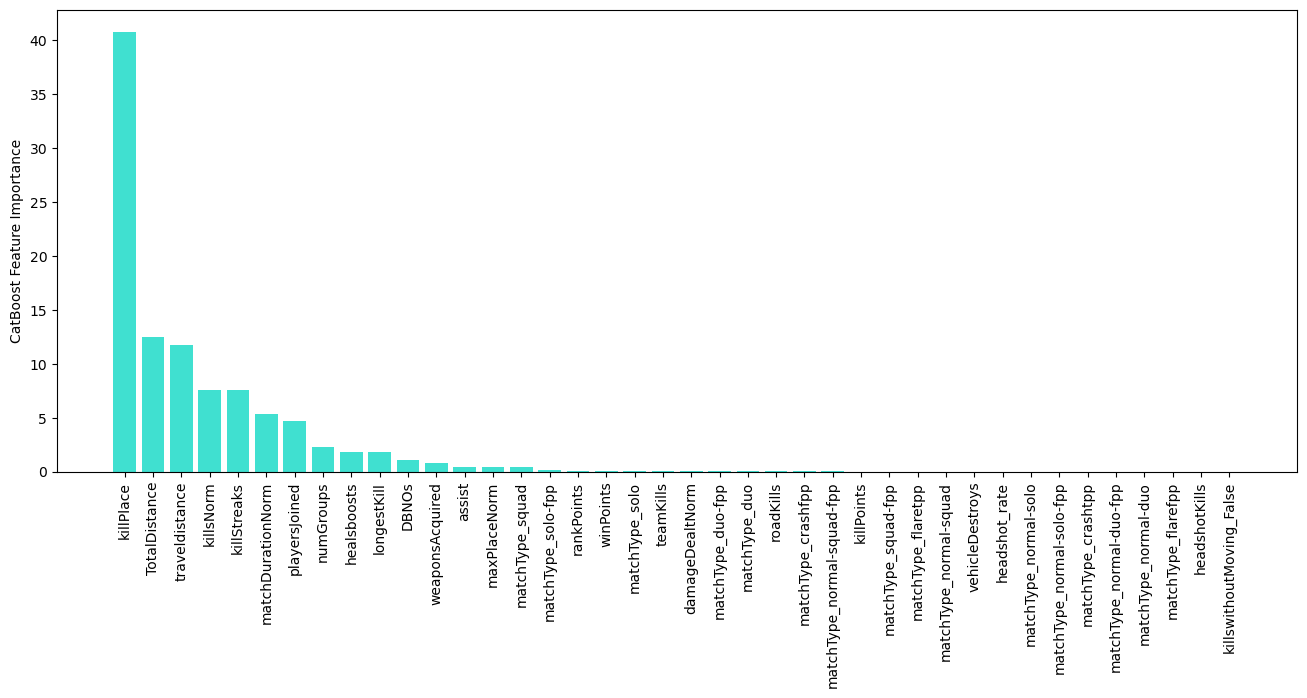

In [82]:
plt.bar(feature_importance_df.features, feature_importance_df.importance, color = 'turquoise')
plt.ylabel("CatBoost Feature Importance")
plt.xticks(rotation = 90)
plt.show()

### Prediction

In [84]:
pred = model.predict(xtest)

In [86]:
rmse = np.sqrt(mean_squared_error(ytest,pred))
r2 = r2_score(ytest,pred)

print("Testing Performance")

print("RMSE: {:.2f}".format(rmse))
print("R2: {:.2f}".format(r2))

Testing Performance
RMSE: 0.08
R2: 0.93


<center><img src = "https://media.giphy.com/media/KB89dMAtH79VIvxNCW/giphy.gif"></center>